#  Loan Default Risk Prediction with Business Cost Optimization

## Introduction
Loan default prediction is a critical problem in the financial sector.
Approving loans for risky customers can result in significant financial losses,
while rejecting reliable customers leads to lost business opportunities.

This task focuses on building a machine learning model that predicts loan
default risk and optimizes decision-making based on business costs rather than
accuracy alone.

# Objectives
The objectives of this task are:
- To predict loan default risk using a binary classification model
- To handle missing values and categorical variables effectively
- To use probability-based predictions instead of fixed thresholds
- To optimize the classification threshold based on business costs
- To minimize costly false negative decisions

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("application_train_input.csv")
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
df.shape


(307511, 122)

In [3]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])


In [4]:
# Fills numeric columns with median
num_cols = X.select_dtypes(include=np.number).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Fills categorical columns with mode
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)


In [5]:
X = pd.get_dummies(X, drop_first=True)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Model Selection
Logistic Regression was used as the baseline classification model due to its
interpretability and suitability for risk prediction problems.


In [7]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
y_prob = log_model.predict_proba(X_test)[:, 1]


In [9]:
COST_FP = 1     # rejecting good customer
COST_FN = 10    # approving bad customer (very costly)


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix

thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = fp * COST_FP + fn * COST_FN
    costs.append(total_cost)


In [11]:
best_threshold = thresholds[np.argmin(costs)]
best_threshold


np.float64(0.1)

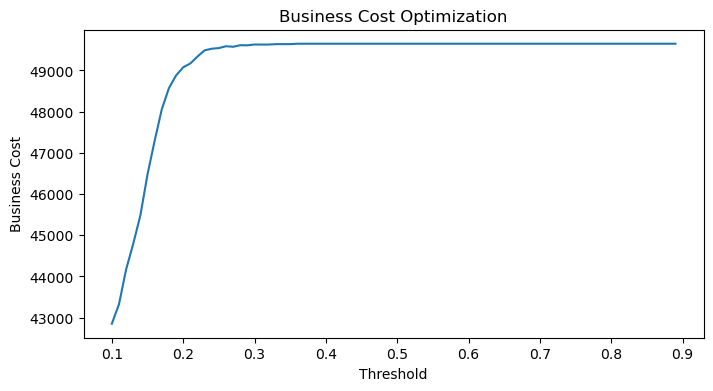

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost Optimization")
plt.show()


In [13]:
y_final = (y_prob >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_test, y_final)


array([[41836, 14702],
       [ 2815,  2150]])

In [14]:
print(classification_report(y_test, y_final))


              precision    recall  f1-score   support

           0       0.94      0.74      0.83     56538
           1       0.13      0.43      0.20      4965

    accuracy                           0.72     61503
   macro avg       0.53      0.59      0.51     61503
weighted avg       0.87      0.72      0.78     61503



In [15]:
task4_output = pd.DataFrame({
    "SK_ID_CURR": df["SK_ID_CURR"],
    "Prediction": log_model.predict(X)
})

task4_output.to_csv("task4_loan_predictions_output.csv", index=False)
print("Task 4 CSV saved successfully")


Task 4 CSV saved successfully
